In [ ]:
import mne
import plotly.graph_objects as go
import numpy as np

# Путь к файлу
file_path = 'data/train_dataset_minzdrav_train/ECoG_fully_marked_(4+2 files, 6 h each)/Ati4x3_12m_BL_6h_fully_marked.edf'
# Какие сегменты и индексы будем отображать (отображение идёт в отсортированном порядке)
available_segments = ['ds']
indices_to_display = (0, 3)

# Загрузка EDF файла
raw = mne.io.read_raw_edf(file_path, preload=True)

# Извлечение данных в numpy массив
data = raw.get_data()
times = raw.times

# Извлечение аннотаций
annotations = raw.annotations

# Создаем словарь для хранения отрезков по типам
segments = {
    'swd1': [], 'swd2': [], 
    'is1': [], 'is2': [],
    'ds1': [], 'ds2': []
}

# Собираем все отрезки по типам
for annotation in annotations:
    onset = int(annotation['onset'] * raw.info['sfreq'])
    description = annotation['description']
    if description in segments:
        segments[description].append(onset)

# Находим последовательные сегменты
consecutive_segments = []
for segment_type in available_segments:
    for i in range(len(segments[segment_type + '1'])):
        consecutive_segments.append((segment_type, i, segments[segment_type + '1'][i]))

# Сортируем по индексу
consecutive_segments.sort(key=lambda x: x[2])

for segment_type, index, _ in consecutive_segments[indices_to_display[0]:indices_to_display[1]]:
    target_onset = segments[segment_type + '1'][index]
    target_duration = segments[segment_type + '2'][index] - target_onset
    
    window_before = int(target_duration)
    window_after = int(target_duration)
    
    start_idx = max(0, target_onset - window_before)
    end_idx = min(len(times), target_onset + target_duration + window_after)
    
    # Создание фигуры с одним графиком
    fig = go.Figure()

    # Определение цветов для каждого типа маркера
    label_colors = {
        'swd1': 'red',
        'swd2': 'red', 
        'is1': 'green',
        'is2': 'green',
        'ds1': 'orange',
        'ds2': 'orange'
    }

    # Добавление всех трех каналов на один график
    # Вычисляем скользящую дисперсию с окном в 100 точек
    window_size = 1000
    rolling_var = np.array([np.var(data[0][i:i+window_size]) for i in range(start_idx, end_idx-window_size)])
    rolling_times = times[start_idx:end_idx-window_size]
    
    # Добавляем исходный сигнал
    fig.add_trace(go.Scatter(x=times[start_idx:end_idx], y=data[0][start_idx:end_idx], name='Канал 1'))
    # Добавляем график дисперсии
    fig.add_trace(go.Scatter(x=rolling_times, y=rolling_var, name='Дисперсия канала 1', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=times[start_idx:end_idx], y=data[1][start_idx:end_idx], name='Канал 2'))
    fig.add_trace(go.Scatter(x=times[start_idx:end_idx], y=data[2][start_idx:end_idx], name='Канал 3'))

    # Добавляем вертикальные линии для обозначения начала и конца события
    fig.add_vline(x=times[target_onset], line_dash="dash", line_color=label_colors[segment_type + '1'], annotation_text=segment_type + '1')
    fig.add_vline(x=times[target_onset + target_duration], line_dash="dash", line_color=label_colors[segment_type + '2'], annotation_text=segment_type + '2')

    # Обновление макета
    fig.update_layout(
        title_text=f"ЭКоГ данные - окно вокруг первого {segment_type} события",
        showlegend=True,
        height=500,
        width=1000,
        xaxis_title='Время (с)',
        yaxis_title='Амплитуда'
    )

    fig.show()

In [10]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mne
from itertools import zip_longest
import numpy as np

# Словари для хранения длин лейблов по всем файлам
label_lengths = {
    'swd': [],
    'is': [], 
    'ds': []
}

# Путь к директории с данными
data_dir = 'data/train_dataset_minzdrav_train/ECoG_fully_marked_(4+2 files, 6 h each)'

# Перебираем все файлы в директории
cnt = 0
for filename in os.listdir(data_dir):
    if 'fully_marked' in filename:
        print(filename)
        file_path = os.path.join(data_dir, filename)
        
        # Загрузка EDF файла
        raw = mne.io.read_raw_edf(file_path, preload=True)
        
        # Извлечение данных и аннотаций
        data = raw.get_data()
        annotations = raw.annotations
        # Словарь для исправления возможных опечаток в названиях
        description_map = {
            'sdw1': 'swd1', 'sdw2': 'swd2',
            'dd1': 'ds1', 'dd2': 'ds2',
            'dds1': 'ds1', 'dds2': 'ds2',
            'swd1': 'swd1', 'swd2': 'swd2',
            'is1': 'is1', 'is2': 'is2', 
            'ds1': 'ds1', 'ds2': 'ds2'
        }
        
        # Временные сегменты для текущего файла
        file_segments = {
            'swd1': [], 'swd2': [], 
            'is1': [], 'is2': [],
            'ds1': [], 'ds2': []
        }

        # Собираем сегменты из текущего файла и проверяем корректность последовательности
        annotations_fixed = []
        current_event = None
        for annotation in annotations:
            onset = int(annotation['onset'])
            description = annotation['description']
            if description not in description_map:
                raise ValueError(f"Неизвестный тип события: {description}")
            
            mapped_description = description_map[description]
            event_base = mapped_description[:-1]  # убираем цифру в конце
            event_num = int(mapped_description[-1])  # получаем цифру
            annotations_fixed.append((mapped_description, onset))
            
            # Проверяем правильность последовательности (1->2)
            if event_num == 1:
                if current_event == event_base:
                    mapped_description = mapped_description[:-1] + '2'
                    event_num = 2
                else:
                    if current_event is not None:
                        file_segments[current_event + '1'].pop()
                    current_event = event_base
            if event_num == 2:
                if current_event is None and annotations_fixed == 'swd':
                    file_segments[event_base + '2'].pop()
                elif current_event != event_base:
                    continue
                current_event = None
                
            file_segments[mapped_description].append(onset)
        
        # Проверяем, что последнее событие закрыто
        if current_event is not None:
            raise ValueError(f"Ошибка: событие {current_event} не закрыто в конце файла")

        # Для каждого типа события в текущем файле
        for event_type in ['swd', 'is', 'ds']:
            # Находим все последовательные сегменты
            for i in range(len(file_segments[event_type + '1'])):
                onset = file_segments[event_type + '1'][i]
                end = file_segments[event_type + '2'][i]
                if end < onset:
                    print(filename, event_type, onset, end, i)
                duration = end - onset
                label_lengths[event_type].append(duration)


Ati4x1_15m_Dex003(Pharm!)_6h_fully_marked.edf
Extracting EDF parameters from /home/mitya/Documents/digital_breakthrough/rats_ecog/ElectrocorticogramClassification/data/train_dataset_minzdrav_train/ECoG_fully_marked_(4+2 files, 6 h each)/Ati4x1_15m_Dex003(Pharm!)_6h_fully_marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8640399  =      0.000 ... 21600.998 secs...
Ati4x3_9m_Xyl01(Pharm!)_6h_fully_marked.edf
Extracting EDF parameters from /home/mitya/Documents/digital_breakthrough/rats_ecog/ElectrocorticogramClassification/data/train_dataset_minzdrav_train/ECoG_fully_marked_(4+2 files, 6 h each)/Ati4x3_9m_Xyl01(Pharm!)_6h_fully_marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8640399  =      0.000 ... 21600.998 secs...
Ati4x1_15m_BL_6h_fully_marked.edf
Extracting EDF parameters from /home/mitya/Documents/digital_breakthrough/rats_ecog/ElectrocorticogramClassification


Статистика для swd по всем файлам:
Матожидание длины: 6.51
Стандартное отклонение: 15.92
Количество событий: 355

Статистика для is по всем файлам:
Матожидание длины: 15.53
Стандартное отклонение: 7.23
Количество событий: 38

Статистика для ds по всем файлам:
Матожидание длины: 237.39
Стандартное отклонение: 430.02
Количество событий: 170


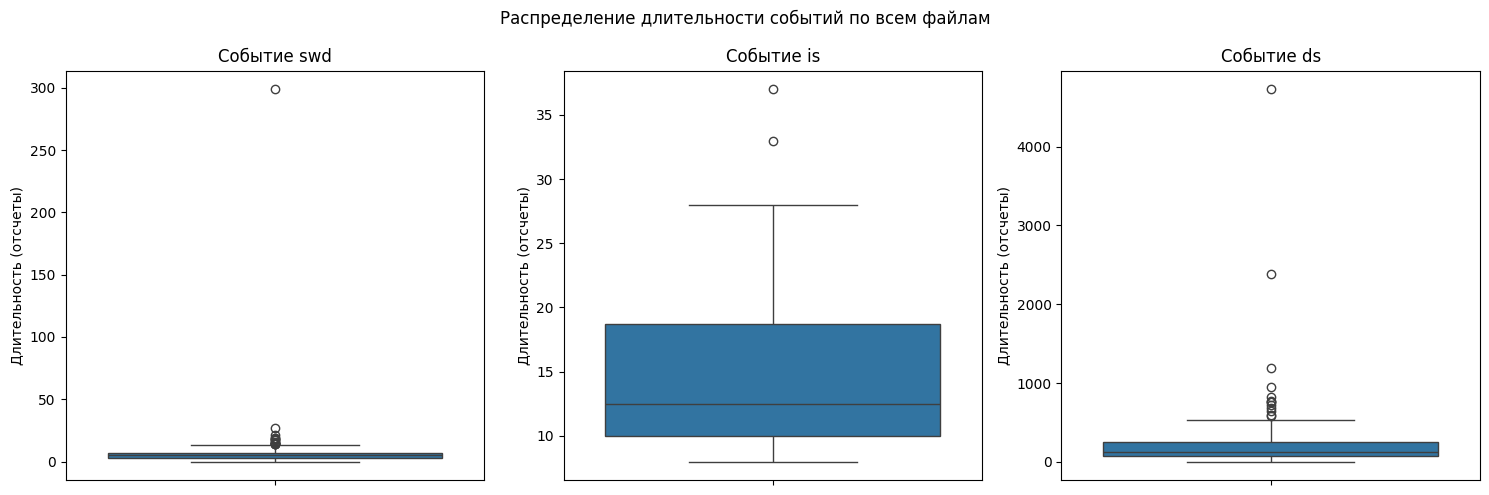

In [12]:
# Вычисляем общие статистики по всем файлам
stats = {}
for event_type, lengths in label_lengths.items():
    stats[event_type] = {
        'mean': np.mean(lengths),
        'std': np.std(lengths),
        'count': len(lengths)
    }
    print(f"\nСтатистика для {event_type} по всем файлам:")
    print(f"Матожидание длины: {stats[event_type]['mean']:.2f}")
    print(f"Стандартное отклонение: {stats[event_type]['std']:.2f}")
    print(f"Количество событий: {stats[event_type]['count']}")

# Создаем отдельные графики для каждого типа события
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Распределение длительности событий по всем файлам')

for idx, (event_type, lengths) in enumerate(label_lengths.items()):
    # Box plot
    sns.boxplot(data=lengths, ax=axes[idx])
    axes[idx].set_title(f'Событие {event_type}')
    axes[idx].set_ylabel('Длительность (отсчеты)')
    
plt.tight_layout()
plt.show()

In [14]:
for ivent_type, lst in label_lengths.items():
    print("Количество событий типа", ivent_type + ':', len(lst))

Количество событий типа swd: 355
Количество событий типа is: 38
Количество событий типа ds: 170
